# Practical work on graph-cut optimization (part 2, multilevel)

The objective of this PW is the implementation of the $\alpha$-expansion and $\alpha$-$\beta$ swap approaches for grayscale image denoising.

The PyMaxFlow library is used to compute the graph-cut.

In [1]:
import math
import random
import numpy as np
from numpy import log
#%matplotlib notebook
import matplotlib.pyplot as plt

import platform
import tempfile
import os
from scipy import ndimage as ndi
try:
    import maxflow
except:
    !pip install PyMaxflow  # For Google Collab
    import maxflow
from maxflow.fastmin import aexpansion_grid, abswap_grid

from skimage import io
import imageio.v2 as imageio
from skimage.morphology import binary_dilation, disk
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.models.mappers import LogColorMapper, LinearColorMapper
from bokeh.io import output_notebook
output_notebook()


def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt = np.clip((imt - MINI) / (MAXI-MINI), 0, 1)
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  if (MINI is not None) and (MAXI is not None):
    img=normalise_image_pour_bokeh(im,MINI,MAXI)
    vmin, vmax = 0., 255.
  else:
    img = im[..., np.newaxis]
    vmin, vmax = np.min(img), np.max(img)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]], title=titre)
  p.image(image=[img[:, :, 0]], x=0, y=0, dw=im.shape[1], dh=im.shape[0], color_mapper=LinearColorMapper(palette="Greys256", low=vmin, high=vmax))
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)


def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # Under Google Colab, many options disappear


def display_segmentation_borders(image, bin):
  imagergb = np.copy(image)
  contour = binary_dilation(bin,disk(15))^bin
  imagergb[contour==1,0] = 255
  imagergb[contour==1,1] = 0
  imagergb[contour==1,2] = 0
  return imagergb

Loading BokehJS ...

## 2 Denoising a grayscale image


In this second part of the PW, we are interested in using Markovian methods to **denoise** images with different regularization potentials.

We are interested in denoising the images *Ibruitee.png* and *Ibruitee2.png* which correspond to the same scene perturbed by two noises of different nature.


We will complete programs that call the algorithm of alpha-expansions or Boykov's alpha-beta swap according to the Kolmogorov technique.


Q1: What are the respective expressions for the data attachment potentials in the case of noise following a Gaussian distribution (equation 1) and a Rayleigh distribution (equation 2)?

\begin{equation}
p(y_p|x_p)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(y_p-x_p)^2}{2\sigma^2}\right],
\end{equation}

\begin{equation}
p(y_p|x_p)=2\frac{y_p}{x_p^2}\exp\left[-\frac{y_p^2}{x_p^2}\right].
\end{equation}

**Your answer &#x270D;**

A1: $$D(y_p,x_p) = -\log p(y_p|x_p)$$

<br>

$D_{Gaussian}(y_p,x_p) = constante + c(y_p-x_p)^2$


$D_{Rayleigh}(y_p,x_p) = constante + 2\log x_p + \frac{y_p^2}{x_p^2}$

Q2: By studying the histogram of a homogeneous area, indicate which type of noise is present in which image.  



**Your answer &#x270D;**

A2: En observant l'histogramme de zones homogènes des images, on observe que l'image 1 a un bruit Gaussien tandis que l'image 2 a un bruit de Rayleigh

In [2]:
im_obs=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png').astype('float') # Observed image, noisy
im_obs2=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee2.png').astype('float') # Observed image, noisy
im_orig=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png').astype('float') # Reference binary image, to evaluate the quality of the segmentation

I = im_obs
affiche(im_obs,MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)

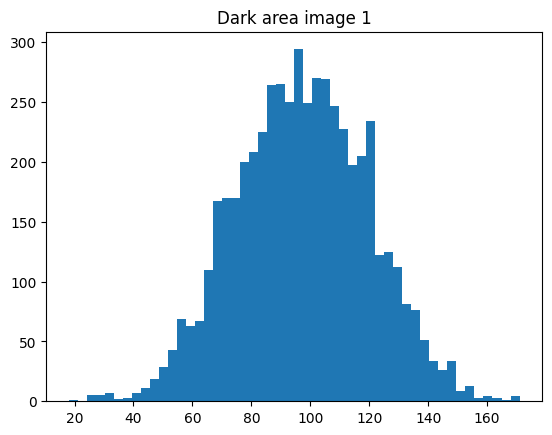

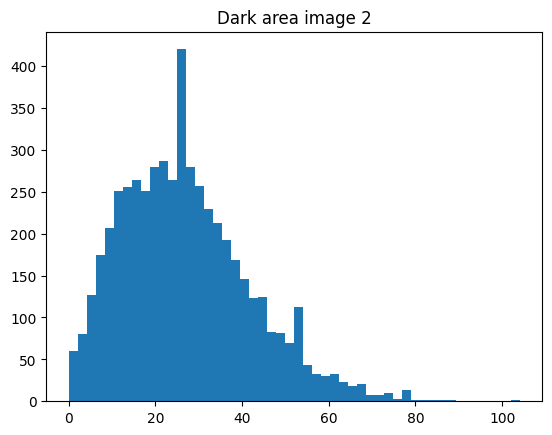

In [7]:
# select a homogeneous area to study the histogram
# we can use the area from 45 to 120 on vertical axis and from 175 to 245 on
# horizontal one
ymin, ymax, xmin, xmax = 45,120,175,245

affiche(im_obs[ymin:ymax, xmin:xmax],MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)
plt.figure()
plt.hist(im_obs[ymin:ymax, xmin:xmax].flatten(),50)
plt.title('Dark area image 1')
plt.show()

affiche(im_obs2[ymin:ymax, xmin:xmax],MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)
plt.figure()
plt.hist(im_obs2[ymin:ymax, xmin:xmax].flatten(),50)
plt.title('Dark area image 2')
plt.show()


We will compare three *a priori* models: the Potts model $\delta_{x_p=x_q}$, the (discrete) total variation $|x_p-x_q|$, and the (quadratic) Gaussian model $(x_p-x_q)^2$.

Q3: Are they metrics or semi-metrics? What can we deduce about the optimization method to use?

**Your answer &#x270D;**

A3:  Le modèle de Potts est metrique, il vérifie l'inégalité triangulaire, l'alpha-beta swap et l'alpha-expansions.

  La variation totale est aussi metrique, l'alpha-beta swap et l'alpha-expansions.

 Alors que le modèle Gaussien est semi-metrique car il ne verifie que l'alpha-beta swap;

Q4: What are the differences between the $\alpha$-expansion method and the $\alpha$-$\beta$ swap method?

**Your answer &#x270D;**

A4: Tout d'abord pour le graphe $\alpha -\beta$ swap seuls les pixels étiquetés en $\alpha -\beta$ sont dans le graph tandis que pour le $\alpha$ expansion tous les pixels sont pris en compte pour la construction du graphe.

De plus, l'énérgie potentielle de régularisation est différente sur les deux méthodes, dans la méthode de alpha expansion on parcours toutes les classes alors que dans le alpha-beta swap on tire les classes deux à deux.

Enfin, pour le alpha-beta swap on utilise du semi-metrique alors que c'est du métrique pour l'autre méthode.

In the following sections we will use the functions **aexpansion_grid** and **abswap_grid** which perform the $\alpha$-expansion and $\alpha$-$\beta$ swap respectively. These functions take as input two arguments for a number of levels L :
- a tensor of the image size containing in the 3rd dimension the data attachment of each pixel for each considered level (unary term, $\texttt{D}$ in the following)
- a matrix containing the values of the interaction terms between two levels $l_1$ and $l_2$ (depends on the chosen interaction potential, $\texttt{V...}$ in the following)

### 2.1 Denoising in the Gaussian case (synthetic image)

In [9]:
# Loading images
im_obs=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png').astype('float') # Observed image, noisy
im_orig=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png').astype('float') # Reference binary image, to evaluate the quality of the segmentation

I = im_obs

I = I*255/I.max()
L = 30
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(1/L, 255, 255/L)
# Calculate data cost as the absolute difference between the label prototype and the pixel value
d = np.double(I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))
D =  np.double(np.abs((I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))**2))  # Complete to compute data attachment potential map from d

affiche(I,MINI=0.0, MAXI=255.,titre="Noisy image",printname=True)

# Generate nearest prototype labeling
Id = np.argmin(D,2)
affiche(Id*255/L,MINI=0.0, MAXI=255.,titre="Maximum likelihood denoising",printname=True)

print("Shape of D:", D.shape)

Shape of D: (323, 361, 30)


Q5: Here, what does the array $\texttt{d}$ correspond to? Explain its dimension.

From this array $\texttt{d}$, compute (in the code) the data attachment potential map $\texttt{D}$ for the considered noise.

**Your answer &#x270D;**

A5: D contient l'attache aux donnés pour chaque pixel d'où l'apparition de la taillle de l'image 323x361 pour chaque niveau d'où le 30

Complete the programs below, and test each regularization model by determining an appropriate beta value each time and an appropriate multi-label graph-cut algorithm.

*Note:* in order to test several values of $\beta$, it is suggested to **crop your image** to 100x100 pixels for example.

In [10]:
# Potts model regularization
# beta values of the order of hundreds/thousands
beta_Potts = 2000 

# definition of the regularization matrix V(i,j) for the Potts model

# HINT1
# Map of the difference between two classes (difference class to class):
d_c2c = levs.reshape((-1,1)) - levs.reshape((1,-1))
# If the regularization potential Vc(x1, x2) of a model is f(x1 - x2), then you
# must define : V_model = f(d_c2c)

# HINT2
# For Potts model, comparing two values is equivalent to compare to difference
# of these two values to some other value...

V_Potts = beta_Potts*np.double(np.abs(d_c2c) > 0)
affiche(V_Potts)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Potts= aexpansion_grid(D,V_Potts) 
affiche(labels_Potts*255/L,MINI=0.0, MAXI=255.0,titre="Graph Cut Denoising, Potts regularization, beta = " + str(beta_Potts),printname=True)

NameError: name 'levs' is not defined

In [22]:
# TV model regularization
# beta value of the order of tens
beta_TV = 30

# definition of the regularization matrix V(i,j) for the TV model
V_TV = beta_TV*np.double(np.abs(d_c2c) > 0)
affiche(V_TV)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_TV = aexpansion_grid(D,V_TV)
affiche(labels_TV*255/L,MINI=0.0, MAXI=255.0,titre="Graph Cut Denoising, TV regularization, beta = " + str(beta_TV),printname=True)

In [25]:
# Quadratic model regularization
# beta value of the order of tens
beta_quadratic = 3

# definition of the regularization matrix V(i,j) for the quadratic model
V_quadratic = beta_quadratic*np.double(d_c2c**2)
affiche(V_quadratic)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Quadratic = aexpansion_grid(D,V_quadratic)
affiche(labels_Quadratic*255/L,MINI=0.0, MAXI=255,titre="Graph Cut Denoising, Quadratic regularization, beta = " + str(beta_quadratic),printname=True)

Q6: Which regularization model do you think is best? Give the best regularization parameter visually found and comment on the results you get in each of the three cases.

**Your answer &#x270D;**

A6: Le modèle le plus adapté est ici celui de Potts, les Beta les plus efficaces sont respectivement : 2000, 40 et 3

### 2.2 Denoising in the case of speckle noise (synthetic image)

Modify the following cells to fit the model for denoising the im_obs2 image.

Q7: Which modifications are needed? (There are several!)

**Your answer &#x270D;**

A7: Nous devons changer le calcul d'attache aux données

In [26]:
from maxflow.fastmin import aexpansion_grid
from numpy import log

# Loading image
im_obs2=io.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee2.png').astype('float') # Observed image, noisy
I = im_obs2
I = I*255/I.max()
affiche(I,MINI=0.0, MAXI=255.,titre="Noisy image 2",printname=True)

L = 30
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(1/L, 255, 255/L)

# Calculate data cost as the absolute difference between the label prototype and the pixel value

# HINT:
# The following computes the ratio between the data value and a class value for
# each class [ys / xs], and you can put a square one only one or both terms.
ratio = I.reshape(I.shape+(1,)) / levs.reshape((1,1,-1))

D = -log(2*ratio**2)+(ratio**2)# Complete data attachment potential map following Rayleigh distribution
Id = np.argmin(D,2)

# Generate nearest prototype labeling
Id = np.argmin(D,2)
affiche(Id/L*255,MINI=0.0, MAXI=255.,titre="Maximum likelihood denoising",printname=True)

C:\Users\khosr\AppData\Local\Temp\ipykernel_29016\3503960968.py:21: RuntimeWarning: divide by zero encountered in log
  D = -log(2*ratio**2)+(ratio**2)# Complete data attachment potential map following Rayleigh distribution


In [34]:
# beta value in the order of tenths of a unit
beta_Potts = 0.45
# definition of the Potts potential matrix
V_Potts = beta_Potts*np.double(np.abs(d_c2c) > 0)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Potts = aexpansion_grid(D,V_Potts)
affiche(labels_Potts*255/L,MINI=0.0, MAXI=255,titre="Graph Cut Denoising, Potts regularization, beta = " + str(beta_Potts),printname=True)

In [36]:
# beta value in hundredths of a unit
beta_TV = 0.05
# definition of the regularization matrix for TV
V_TV = beta_TV*np.double(np.abs(d_c2c) > 0)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_TV = aexpansion_grid(D,V_TV)
affiche(labels_TV*255/L,MINI=0.0, MAXI=255,titre="Graph Cut Denoising, TV regularization, beta = " + str(beta_TV),printname=True)

In [38]:
# beta value in the order of thousandths of a unit
beta_quadratic = 0.001
# definition of the regularization matrix for a quadratic potential
V_quadratic = beta_quadratic*np.double(d_c2c**2)

# Performs aexpansion_grid or abswap_grid based on the data attachment D and the regularization V
labels_Quadratic = aexpansion_grid(D,V_quadratic)
affiche(labels_Quadratic*255/L,MINI=0.0, MAXI=255.,titre="Graph Cut Denoising, Quadratic regularization, beta = " + str(beta_quadratic),printname=True)

### 2.3 Denoising a natural image

Apply one of the methods used above to denoise the noisy cameraman image. Justify your choice.

*Note:* you should check how the noise is generated to choose your data attachment term.

Q8: Comment on the result obtained.

**Your answer &#x270D;**

A8: J'utilise ici la méthode TV car vu les test faits précedemment le resultat serait mieux pour une image "non segmentée".
Puisque TV est métrique j'utilise alors une alpha-expansion

Pour ce qui est du resultat on garde les informations importantes : un homme qui regarde dans un appareil photo et en fond des bâtiments cependant on perds les détails.

In [39]:
I_cameraman = imageio.imread('https://people.math.sc.edu/Burkardt/data/tif/cameraman.tif')
I_cameraman_bruit = I_cameraman + np.random.normal(0,80,I_cameraman.shape)
I_cameraman_bruit[I_cameraman_bruit<0] = 0
I_cameraman_bruit[I_cameraman_bruit>255] = 255

affiche(I_cameraman, MINI=0.0, MAXI=255,titre="Image without noise",printname=True)
affiche(I_cameraman_bruit, MINI=0.0, MAXI=255,titre="Noisy image",printname=True)

In [44]:
I = 255*I_cameraman_bruit/I.max()
L = 250
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(0,255,255/L)
# Calculate data cost as the absolute difference between the label prototype and the pixel value
D = np.double(np.abs((I.reshape(I.shape+(1,)) - levs.reshape((1,1,-1)))**2))


# choose a regularization model and compute V matrix
beta_TV= 90
V_TV = beta_TV*np.double((np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1)))))

# compute the appropriate optimization
labels_TV=aexpansion_grid(D,V_TV)
# display the regularized image
affiche(labels_TV, MINI=0.0,MAXI=None,titre="Débruitage par Graph Cut, regularisation Quadratic, beta = " + str(beta_TV),printname=True)

### 2.3 SAR Image Denoising

SAR (Synthetic Aperture Radar) imagery is a radar-based remote sensing modality that provides images of the Earth in all light and weather conditions. A major drawback is the high speckle noise that affects them. The following cell loads an amplitude image acquired by the Sentinel 1-A satellite over the city of Des Moines in the USA. To limit the computation time, we will work on a small rectangle from the image provided.

Adapt one of the methods used previously to denoise the image provided. We will assume that the noise follows a Rayleigh distribution.

Q9: Comment on the result obtained.

We can compare the result with a denoising obtained by a more recent method (SAR2SAR), based on a Deep Learning approach (the code to display it is provided below).

**Your answer &#x270D;**

A9: le programme prends bizarrement beaucoup de temps avec la méthode TV

Fichier téléchargé et enregistré sous noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy
Fichier chargé avec succès


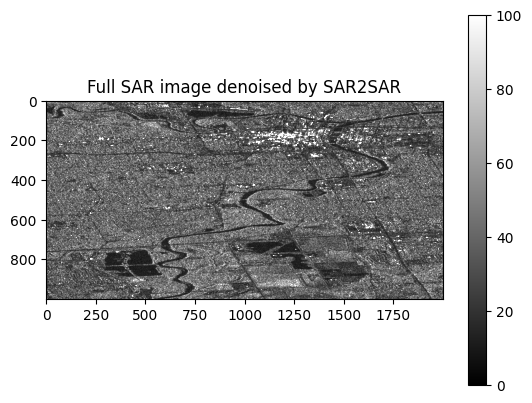

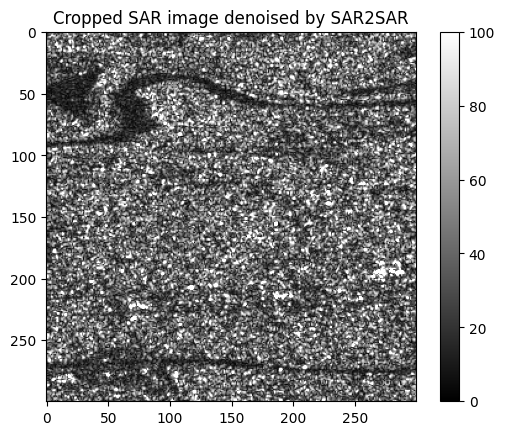

In [46]:
import urllib.request
import numpy as np

# URL du fichier
url = 'https://www.dropbox.com/s/7m2dw3irho8dpzj/noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1'
local_filename = 'noisy_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy'

# Télécharger le fichier
try:
    urllib.request.urlretrieve(url, local_filename)
    print(f"Fichier téléchargé et enregistré sous {local_filename}")
except Exception as e:
    print(f"Erreur lors du téléchargement du fichier : {e}")

# Charger le fichier avec numpy
try:
    I_SAR = np.load(local_filename)
    print("Fichier chargé avec succès")
except Exception as e:
    print(f"Erreur lors du chargement du fichier : {e}")

# Afficher l'image (si nécessaire)
import matplotlib.pyplot as plt

def affiche(image, MINI=0, MAXI=100, titre="Image"):
    plt.imshow(image, cmap='gray', vmin=MINI, vmax=MAXI)
    plt.title(titre)
    plt.colorbar()
    plt.show()

affiche(I_SAR, MINI=0, MAXI=100, titre="Full SAR image denoised by SAR2SAR")
affiche(I_SAR[0:300, 0:300], MINI=0, MAXI=100, titre="Cropped SAR image denoised by SAR2SAR")

In [48]:
I = I_SAR*255/I_SAR.max()
L = 255
# Generates L gray levels for nearsest prototype labeling
levs = np.arange(1/L,255,255/L)
# Calculate data cost as the neg-log likelihood
D = -np.log(I.reshape(I.shape+(1,))/levs.reshape((1,1,-1)))

# choose a regularization model and compute V matrix
beta_TV= 0.1
V_TV = beta_TV*np.double((np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1)))))
# compute the appropriate optimization
labels_TV=aexpansion_grid(D,V_TV)
# display the regularized image: you must invert previous grayscale dynamic transformations.
affiche(labels_TV*255/L,MINI=0.0,MAXI=255.,titre="Graph Cut Denoising, TV regularization, beta = " + str(beta_TV),printname=True)


KeyboardInterrupt: 

In [ ]:
# Display of the denoised image by the SAR2SAR method

try:
    denoised_I_SAR = np.load('denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')
except:
    !wget 'https://www.dropbox.com/s/0f6l0qr6teck5bd/denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1'
    denoised_I_SAR = np.load('denoised_DesMoines_dual_1_corrige_1_VV_AMPLITUDE.npy?dl=1')

affiche(denoised_I_SAR,MINI=0,MAXI=100, titre="Full SAR image denoised by SAR2SAR")
affiche(denoised_I_SAR[0:300,0:300],MINI=0,MAXI=100, titre="Cropped SAR image denoised by SAR2SAR")

plt.figure()
plt.hist(denoised_I_SAR[100:200,100:200].flatten(),200) # Display of the histogram on an almost homogeneous area
plt.show()